In [1]:
import os
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
import umap.umap_ as umap
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import random
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
import plotly.graph_objects as go
nltk.download('stopwords', quiet=True, raise_on_error=True, download_dir='../models/nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='../models/nltk_data')

True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
model = SentenceTransformer("all-MiniLM-L6-v2")

def postprocess_text(text):
    stop_words_extended = [
        "ooh",
        "oh",
        "ah",
        "yeah",
        "la",
        "na",
        "da",
        "hey",
        "whoa",
        "whoah",
        "mm",
        "uh",
        "huh",
        "hmm",
        "hey",
        "yeah",
        "oh",
        "ooh",
        "ah",
        "la",
        "na",
        "da",
        "whoa",
        "na",
        "poland",
        "polish",
        "vs",
        "gon",
        "poppy"
        "re",
        "ve",
        "ll",
        "m",
        "s",
        "t",
        "d",
    ]
    text = text.lower()
    for unwanted in stop_words_extended:
        text = text.replace(unwanted, "")
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

In [3]:
def load_and_preprocess(data_dir):
    all_data = []

    for country in os.listdir(data_dir):
        country_path = os.path.join(data_dir, country)
        if not os.path.isdir(country_path):
            continue

        for category_file in os.listdir(country_path):
            category_path = os.path.join(country_path, category_file)
            if not category_file.endswith(".json"):
                continue

            with open(category_path, "r") as f:
                channels = json.load(f)
            for channel in channels:
                videos = channel["videos"]
                for video in videos:
                    video["country"] = country
                    video["category"] = os.path.splitext(category_file)[0]
                    video["title"] = postprocess_text(video["title"])
                    all_data.append(video)

    df = pd.DataFrame(all_data)
    df["date"] = pd.to_datetime(df["date"])

    min_date = df["date"].min()
    df["normalized_date"] = (df["date"] - min_date).dt.total_seconds() / (24 * 60 * 60)

    return df

In [5]:
data_dir = "../data/videos/preprocessed"
df = load_and_preprocess(data_dir)

In [ ]:
def get_embeddings(df):
    embeddings = model.encode(df["title"].tolist(), show_progress_bar=True)
    return embeddings

def get_clusters(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels

In [9]:
def reduce_dimensions(features, method="pca", **kwargs):
    if method == "pca":
        reducer = PCA(n_components=2, **kwargs)
    elif method == "umap":
        reducer = umap.UMAP(n_components=2, **kwargs)
    elif method == "tsne":
        reducer = TSNE(n_components=2, **kwargs)
    else :
        raise ValueError(f"Unknown method {method}")
    reduced_features = reducer.fit_transform(features)
    return reduced_features

In [10]:
def get_top_words(centroids, vectorizer: CountVectorizer, n=20):
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_words = [feature_names[np.argsort(-centroid)[:n]] for centroid in centroids]
    return [", ".join(words) for words in top_words]

In [11]:
def interactive_chart(df, cluster_topics):
    df["cluster_topic"] = df["cluster"].map(cluster_topics)
    for category in df["category"].unique():
        category_df = df[df["category"] == category]
        fig = px.scatter(
            category_df,
            x="normalized_date",
            y="cluster",
            color="country",
            hover_data={"title": True, "author": True, "cluster_topic": True},
            title=f"Clustering for Category: {category}",
            labels={"normalized_date": "Days Since Min Date", "cluster": "Cluster"},
        )
        fig.show()

In [12]:
def visualize_clusters_2d(reduced_features, cluster_labels, x_axis_range=None, y_axis_range=None):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        x=reduced_features[:, 0],
        y=reduced_features[:, 1],
        hue=cluster_labels,
        palette="tab10",
        s=100,
        alpha=0.5,
    )
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.xlim(x_axis_range)
    plt.ylim(y_axis_range)
    plt.show()

In [ ]:
entertainment_df_all = df[df['category'] == 'Entertainment']
features, vectorizer = get_embeddings(entertainment_df_all)
reduced_features = reduce_dimensions(features, method='tsne')
entertainment_df_all = (entertainment_df_all.copy(), reduced_features, n_clusters=10)
cluster_labels = entertainment_df_all['cluster'].values
visualize_clusters_2d(reduced_features, cluster_labels, x_axis_range=(-30, 30), y_axis_range=(-30, 30))

In [ ]:
cluster_topics = extract_top_words_per_cluster(vectorizer, features, cluster_labels, top_n=10)
cluster_topics

In [ ]:
interactive_chart(entertainment_df_all, cluster_topics)

In [15]:
def compute_cluster_centroids(features, labels):
    clusters = np.unique(labels)
    centroids = []

    for cluster in clusters:
        cluster_indices = np.where(labels == cluster)[0]
        cluster_vectors = features[cluster_indices]
        centroid = cluster_vectors.mean(axis=0)
        centroids.append(centroid)

    return np.array(centroids)


def compute_similarity_between_clusters(centroids_poland, centroids_us):
    similarity_matrix = cosine_similarity(centroids_poland, centroids_us, dense_output=True)
    return similarity_matrix

In [87]:
def genre_distribution(df):
    genre_distribution = df["category"].value_counts()
    genre_distribution = genre_distribution / genre_distribution.sum()
    return genre_distribution


def plot_genre_distribution(genre_distribution, country):
    data = [go.Pie(labels=genre_distribution.index, values=genre_distribution.values)]
    fig = go.Figure(data)
    fig.update_layout(
        title=f"Genre Distribution for {country}",
        title_font=dict(size=20),
        showlegend=True,
        width=600,
        height=600,
        margin=dict(l=0, r=0, t=50, b=0),
        font=dict(size=16),
        legend=dict(orientation="h", xanchor="right", x=1),
        legend_title_text="Genre",
    )
    fig.update_traces(textposition="inside", textinfo="percent+label")
    fig.show()

In [88]:
genre_distribution_country = genre_distribution(df[df["country"] == 'poland'])
plot_genre_distribution(genre_distribution_country, "Poland")
genre_distribution_country = genre_distribution(df[df["country"] == 'united-states'])
plot_genre_distribution(genre_distribution_country, "United States")

In [ ]:
def visualize_with_topics(similarity_matrix, top_words_poland, top_words_us, category):
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=[f"{i}" for i in range(len(top_words_poland))],
        columns=[f"{i}" for i in range(len(top_words_us))],
    )
    hover_text = [
        [
            f"Poland Cluster {i}: {top_words_poland[i]}<br>US Cluster {j}: {top_words_us[j]}<br>Similarity: {similarity_matrix[i, j]:.2f}"
            for j in range(similarity_matrix.shape[1])
        ]
        for i in range(similarity_matrix.shape[0])
    ]

    fig = go.Figure(
        data=go.Heatmap(
            z=similarity_df.values,
            x=similarity_df.columns,
            y=similarity_df.index,
            colorscale="Viridis",
            hoverongaps=False,
            text=hover_text,
            hoverinfo="text",
        )
    )

    fig.update_layout(
        title="Cluster Similarity Between Poland and US - " + category,
        xaxis_title="US Clusters",
        yaxis_title="Poland Clusters",
        height=800,
        width=1000,
    )

    for i in range(len(similarity_df.index)):
        for j in range(len(similarity_df.columns)):
            fig.add_annotation(
                x=similarity_df.columns[j],
                y=similarity_df.index[i],
                text=str(similarity_df.values[i, j].round(2)),
                showarrow=False,
                xref="x1",
                yref="y1",
                font=dict(
                    color=(
                        "white"
                        if similarity_df.values[i, j] < max(similarity_df.values.flatten()) / 2
                        else "black"
                    )
                ),
            )

    fig.write_html(f"cluster_similarity_{category}.html")

    fig.show()

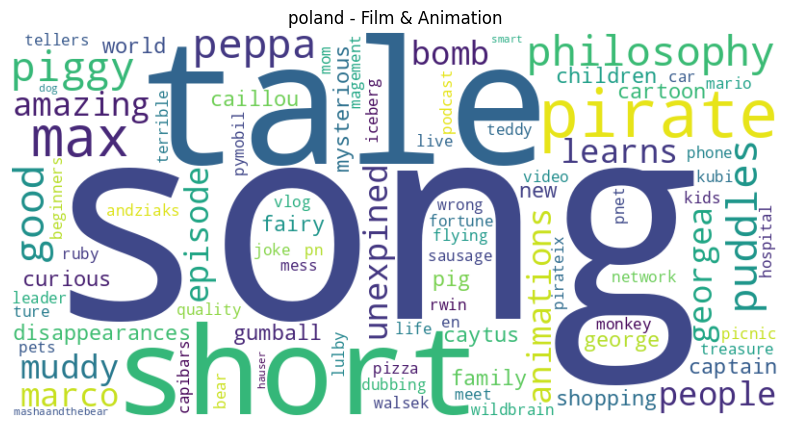

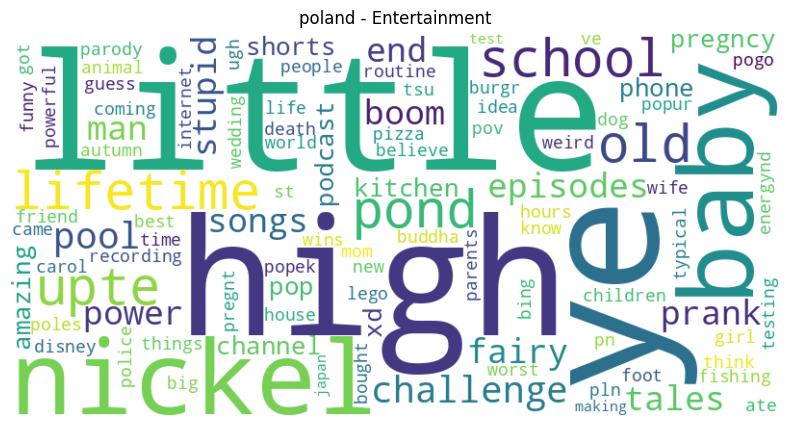

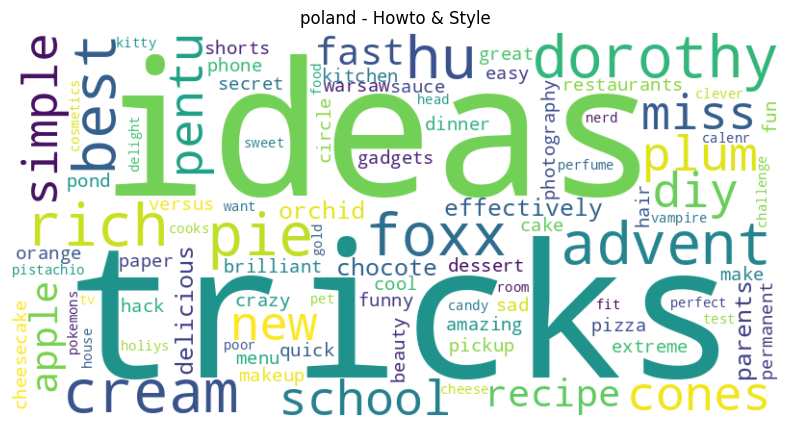

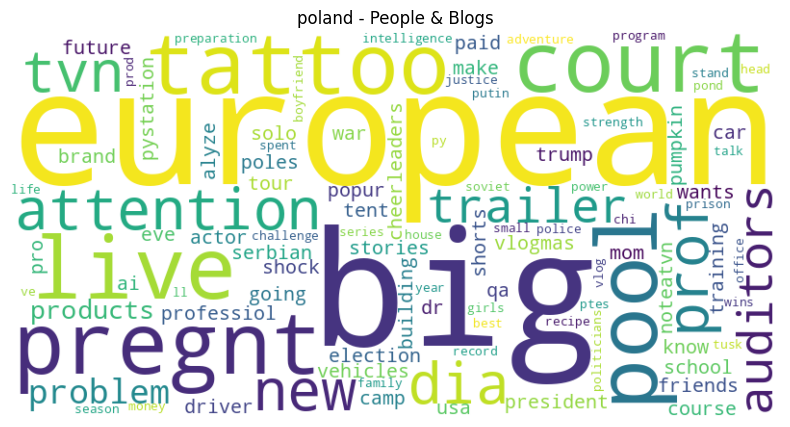

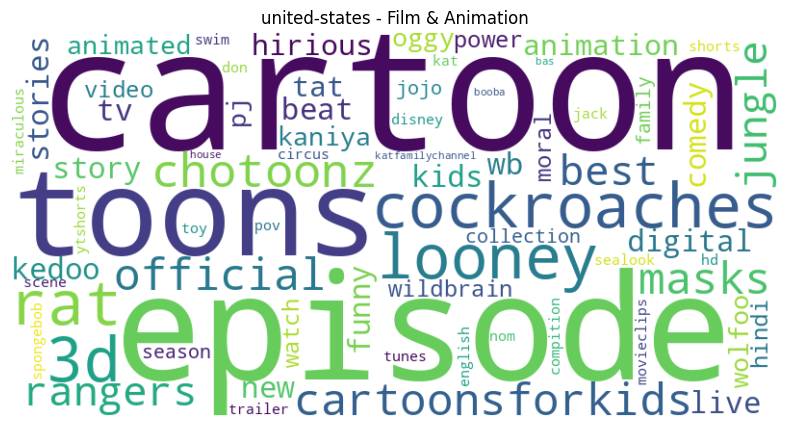

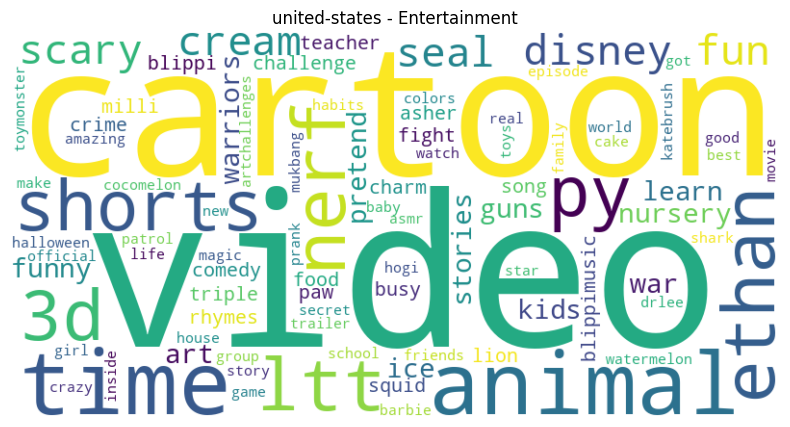

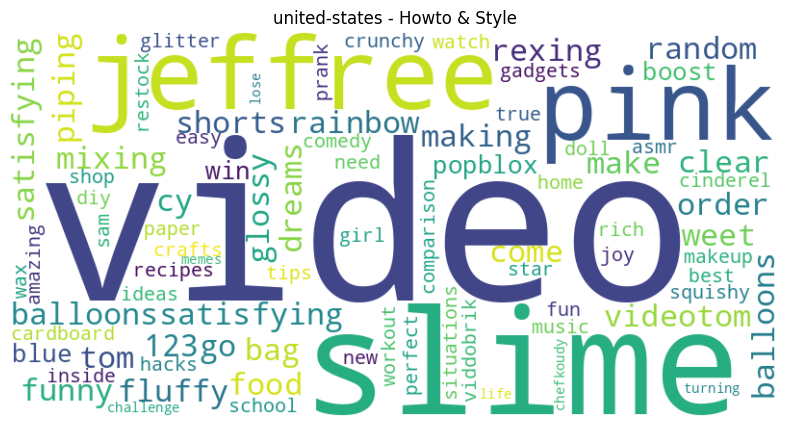

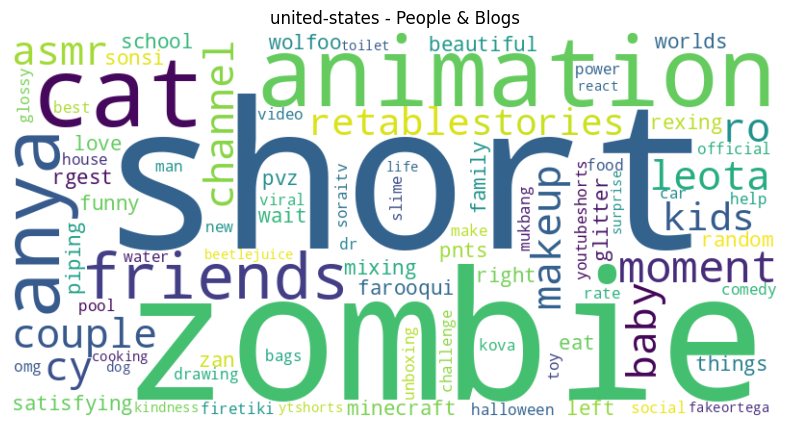

In [ ]:
def word_clouds_per_country_and_category(df):
    for country in df["country"].unique():
        for category in df["category"].unique():
            category_df = df[(df["country"] == country) & (df["category"] == category)]
            features, vectorizer = get_embeddings(category_df)
            reduced_features = reduce_dimensions(features, method="pca")
            category_df = perform_clustering_kemans(category_df.copy(), reduced_features, n_clusters=10)
            cluster_labels = category_df["cluster"].values
            cluster_centroids = compute_cluster_centroids(features.toarray(), cluster_labels)
            top_words = get_top_words(cluster_centroids, vectorizer, n=20)
            unique_words = set(" ".join(top_words).split())
            wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(unique_words))
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"{country} - {category}")
            plt.show()

word_clouds_per_country_and_category(df)

In [18]:
def find_optimal_clusters_silhouette(features, max_clusters=20):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        score = silhouette_score(features, cluster_labels)
        silhouette_scores.append(score)
    best_n_clusters = np.argmax(silhouette_scores)
    return best_n_clusters

In [21]:
def analyze_similarity(category):
    df_entertainment_poland = df[(df["category"] == category) & (df["country"] == "poland")]
    df_entertainment_us = df[(df["category"] == category) & (df["country"] == "united-states")]

    features_poland, vectorizer_poland = extract_features_with_ngrams(df_entertainment_poland)
    features_us, vectorizer_us = extract_features_with_ngrams(df_entertainment_us)

    normalized_features_poland = normalize(features_poland)
    normalized_features_us = normalize(features_us)

    n_clusters = find_optimal_clusters_silhouette(normalized_features_poland, max_clusters=10)

    kmeans_params = {
        "n_clusters": n_clusters,
        "random_state": 20010805,
    }

    # dbscan_params = {
    #     'eps': 0.5,
    #     'min_samples': 15,
    #     'metric': 'cosine',
    # }
    # cluster_labels_poland = perform_clustering_dbscan(df_entertainment_poland.copy(), normalized_features_poland, **dbscan_params)['cluster'].values
    # cluster_labels_us = perform_clustering_dbscan(df_entertainment_us.copy(), normalized_features_us, **dbscan_params)['cluster'].values

    cluster_labels_poland = perform_clustering_kemans(
        df_entertainment_poland.copy(), normalized_features_poland, **kmeans_params
    )["cluster"].values
    cluster_labels_us = perform_clustering_kemans(
        df_entertainment_us.copy(), normalized_features_us, **kmeans_params
    )["cluster"].values

    centroids_poland = compute_cluster_centroids(
        normalized_features_poland.toarray(), cluster_labels_poland
    )
    centroids_us = compute_cluster_centroids(normalized_features_us.toarray(), cluster_labels_us)

    top_words_poland = get_top_words(centroids_poland, vectorizer_poland)
    top_words_us = get_top_words(centroids_us, vectorizer_us)

    similarity_matrix = compute_similarity_between_clusters(centroids_poland, centroids_us)
    visualize_with_topics(similarity_matrix, top_words_poland, top_words_us, category)

In [20]:
for category in df["category"].unique():
    analyze_similarity(category)

KeyboardInterrupt: 